In [1]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
from itertools import product
import matplotlib.pyplot as plt
import tsplib95

In [2]:
problem = tsplib95.load_problem('cities/eil51.tsp')
cities = []
maxCities = 30
for i in range(1, problem.dimension):
    cities.append(problem.get_display(i))

In [3]:
def distance_between_cities(cities, i, j):
    city = cities[i]
    second_city = cities[j]
    return np.sqrt((second_city[0] - city[0])**2 + (second_city[1] - city[1])**2)

In [4]:
def func_distance(x, cities):
    sum=0;
    
    for j in range(len(x) - 1):
        i1 = x[j]
        i2 = x[j + 1]
        city = cities[i1]
        second_city = cities[i2]
        sum += np.sqrt((second_city[0] - city[0])**2 + (second_city[1] - city[1])**2)
    return sum

In [5]:
def func_distance_with_drone(x, drones, cities, p):
    filteredX = []
    filteredX.append(x[0])
    for j in range(1, len(x)):
        if not (drones[j-1] == 0 and drones[j] == 1):
            filteredX.append(x[j])
        
        
    d_t = []
    for j in range(len(filteredX) - 1):
        i1 = x[j]
        i2 = x[j + 1]
        city = cities[i1]
        second_city = cities[i2]
        sum = np.sqrt((second_city[0] - city[0])**2 + (second_city[1] - city[1])**2)
        d_t.append(sum)
    
    d_d = []
    sum = 0
    i = 1
    while i < len(drones):
        if drones[i] == 1:
            i1 = x[i-1]
            i2 = x[i]
            city = cities[i1]
            second_city = cities[i2]
            sum += np.sqrt((second_city[0] - city[0])**2 + (second_city[1] - city[1])**2)
        if drones[i - 1] == 1 and drones[i] == 0:
            i1 = x[i-1]
            i2 = x[i]
            city = cities[i1]
            second_city = cities[i2]
            sum += np.sqrt((second_city[0] - city[0])**2 + (second_city[1] - city[1])**2)
            d_d.append(sum*p)
            sum = 0
        if drones[i - 1] == 0 and drones[i] == 0:
            sum = 0
            d_d.append(sum*p)
            
        i += 1
        
    sum = 0
    #print("sum=", x, drones)
    #print("sum=", d_t, d_d)
    for i in range(len(d_d)):
        sum += max(d_t[i], d_d[i])
        
    return sum

In [6]:
def func_distance_with_drone(x, drones, cities, p):
    sum = 0
    tempSumVehicle = 0
    tempSumDrone = 0
    tempIndexCityDrone = 0
    tempIndexCityVehicle = 0
    tempCities = cities.copy()
    tempCities.append(cities[0])
    tempX = np.append(x, 0)
    tempDrones = np.append(drones, 0)
    for i in range(1, len(tempX)):
        if tempDrones[i - 1] == 0 and tempDrones[i] == 0:
            current_distance = distance_between_cities(tempCities, tempX[i-1], tempX[i])
            sum += current_distance
            
            
        if tempDrones[i - 1] == 0 and tempDrones[i] == 1:
            current_distance = distance_between_cities(tempCities, tempX[i-1], tempX[i])
            tempSumDrone += current_distance
            tempIndexCityVehicle = tempX[i-1]
            tempIndexCityDrone = tempX[i]
        
        if tempDrones[i - 1] == 1 and tempDrones[i] == 1:
            current_distance = distance_between_cities(tempCities, tempIndexCityVehicle, tempX[i])
            tempSumVehicle += current_distance
            tempIndexCityVehicle = tempX[i]
        
        if tempDrones[i - 1] == 1 and tempDrones[i] == 0:
            current_distance_vehicle = distance_between_cities(tempCities, tempIndexCityVehicle, tempX[i])
            tempSumVehicle += current_distance_vehicle
            
            current_distance_drone = distance_between_cities(tempCities, tempIndexCityDrone, tempX[i])
            tempSumDrone += current_distance_drone
            
            sum += max(current_distance_vehicle, current_distance_drone * p)
            tempSumVehicle = 0
            tempSumDrone = 0
    return sum
                
        
    

In [7]:
class GeneticAlgorithm:
    def __init__(self, pop_size = 50, cross_rate=0.25,
                 mutation_rate=0.01, func=None, cities = None, p = 0.5):
        self.func_to_minimize = func
        self.pop_size = pop_size
        self.cross_rate = cross_rate
        self.mutation_rate = mutation_rate
        self.number_of_evaluations = 0
        self.cities = cities
        self.dimension = len(cities)
        self.p = p
    
    def func(self, X, drones, cities, p):
        self.number_of_evaluations += 1
        return 1 / (self.func_to_minimize(X,drones, cities, p))
    
        
    def generatePopulation(self):
        population = []
        for i in range(self.pop_size):
             population.append(self.generateRandom())
        return population
    
    def generatePopulationForDrones(self):
        drones_population = []
        for i in range(self.pop_size):
             drones_population.append(self.generateRandomDrone())
        return drones_population
    
    def generateRandom(self):
        chromosome = np.arange(1, self.dimension)
        np.random.shuffle(chromosome)
        return np.insert(chromosome, 0, 0, axis=0)
    
    def generateRandomDrone(self):
        drones_chromosome = []
        x = 0
        drones_chromosome.append(x)
        for i in range(1, self.dimension):
            if(random.uniform(0, 1) > 0.5):
                x = 1
            else:
                x = 0
            drones_chromosome.append(x)  
        return drones_chromosome
    
    def swap(self, chromosome):
        index1 = np.random.randint(1,self.dimension)
        index2 = np.random.randint(1,self.dimension)
        
        
        temp = chromosome[index1]
        chromosome[index1] = chromosome[index2]
        chromosome[index2] = temp
        return chromosome
    
    def changeBit(self, bite_array, position = None):
        bit_length = len(bite_array)
        index = position
        bite_array = list(bite_array)
        if bite_array[index] == 0:
            bite_array[index] = 1
        else:
            bite_array[index] = 0
        return bite_array
    
    def mutationDrones(self):
        for i in range(len(self.population_drones)):
            for mutation_point in range(1, len(self.cities) - 1):
                if(random.uniform(0, 1) < self.mutation_rate):
                    self.population_drones[i] = self.changeBit(self.population_drones[i], mutation_point)

        
        
    def evaluatePopulation(self):
        return self._evaluatePopulation(self.population, self.population_drones, self.cities, self.p)
    
    def _evaluatePopulation(self, population, population_drones, cities, p):
        evaluatePopulation = []
        for j in range(len(population)):
            chromosome = population[j]
            drone = population_drones[j]
            value = self.func(chromosome, drone, cities, p)
            evaluatePopulation.append(value)
        
        return evaluatePopulation
            
    
    
    def wheel_of_fortune_based_on_rank(self):
        minimum = np.min(self.population_evaluation)
        population_evaluation = self.population_evaluation[:]
        
        indexes = np.argsort(self.population_evaluation[:])
        
        population = np.asarray(self.population)[indexes]
        
        rank_population = np.arange(1, self.pop_size)
        
          
        total_fitness = np.sum(rank_population)
        fitness_per_chromosome = rank_population / total_fitness
        
        
        q = []
        q.append(0.0)
        cumulative_probability = 0
        for fitness in fitness_per_chromosome:
            cumulative_probability += fitness
            q.append(cumulative_probability)
        
        selection = []
        for j in range(self.pop_size):
            fortune =  random.uniform(0, 1)
            for i in range(self.pop_size):
                if q[i] <= fortune and fortune <= q[i+1]:
                    selection.append(population[i][:])
        return selection
    
    
    
    def wheel_of_fortune(self):
        population_evaluation = self.population_evaluation[:]
          
        total_fitness = np.sum(population_evaluation)
        
        fitness_per_chromosome = np.asarray(population_evaluation) / total_fitness
        q = []
        q.append(0.0)
        cumulative_probability = 0
        for fitness in fitness_per_chromosome:
            cumulative_probability += fitness
            q.append(cumulative_probability)
        selection = []
        for j in range(self.pop_size):
            fortune =  random.uniform(0, 1)
            for i in range(self.pop_size):
                if q[i] <= fortune and fortune <= q[i+1]:
                    selection.append(self.population[i][:])
        return selection
    
    
    def cross_over(self):
        indexes_for_cross_over = []
        for i in range(1, len(self.population)):
            if(random.uniform(0, 1) < self.cross_rate):
                indexes_for_cross_over.append(i)
        
        np.random.shuffle(indexes_for_cross_over)
        
        if(len(indexes_for_cross_over) % 2 == 1):
            indexes_for_cross_over.pop()
        
        for i in range(0, len(indexes_for_cross_over), 2):
            idx1 = indexes_for_cross_over[i]
            idx2 = indexes_for_cross_over[i + 1]
            
            parent1 = self.population[idx1]
            parent2 = self.population[idx2]
            child1 = self._cross_over(parent1, parent2)
            child2 = self._cross_over(parent2, parent1)
            
            self.population[idx1] = child1
            self.population[idx2] = child2
            
    def _cross_over(self, parent1, parent2):
        
        start_cross_point = np.random.randint(1, self.dimension)
        end_cross_point = np.random.randint(1, self.dimension)
        child = [None] * self.dimension
        for i in range(len(child)):
            if start_cross_point < end_cross_point and i > start_cross_point and i < end_cross_point:
                child[i] = parent1[i]
            elif start_cross_point > end_cross_point:
                if not (i < start_cross_point and i > end_cross_point):
                    child[i] = parent1[i]

        for i in range(len(parent2)):
            if parent2[i] not in child:
                for j in range(len(child)):
                    if child[j] is None:
                        child[j] = parent2[i]
                        break
        return np.array(child)
            
        
    
    def mutation(self):
        for i in range(len(self.population)):
            if(random.uniform(0, 1) < self.mutation_rate):
                self.population[i] = self.swap(self.population[i])
    
    
    def printBestCurrent(self):
        idx = np.argmax(self.population_evaluation)
        #print("Best current value = " + str(self.func_to_optimize(self.population[idx])))
    
    
    
    def run_genetic_algorithm(self):
        self.population = self.generatePopulation()
        self.population_drones = self.generatePopulationForDrones()
#         print(self.population[0], self.population_drones[1])
        self.population_evaluation = self.evaluatePopulation()
        max = - math.inf
        values = []
        value = None
        x = None
        drone = None
        idx = None
        for i in range(self.number_of_generations):
            if self.selection_type == 'rank':
                self.population = self.wheel_of_fortune()
            else:
                self.population = self.wheel_of_fortune_based_on_rank()
            self.cross_over()
            self.mutation()
            self.mutationDrones()
            self.population_evaluation = self.evaluatePopulation()
            idx = np.argmax(self.population_evaluation)
            if(max < self.population_evaluation[idx]):
                max = self.population_evaluation[idx]
                value = self.func_to_minimize(self.population[idx], self.population_drones[idx],  self.cities, self.p)
                x = self.population[idx]
                drone = self.population_drones[idx]
            values.append(self.func_to_minimize(self.population[idx], self.population_drones[idx],  self.cities, self.p))
        
        return values, self.number_of_evaluations, values[-1], x, drone
        
    
    def run(self, number_of_generations = 1, selection_type='fitness'):
        self.number_of_generations = number_of_generations
        self.selection_type = selection_type
        return self.run_genetic_algorithm()

In [8]:
# model = GeneticAlgorithm(pop_size=200, cross_rate=0.005,
#                      mutation_rate=0.005, func = func_distance_with_drone, cities = cities10, p = 0.5)
# values, number_of_evaluations, last_value, x, drone = model.run(number_of_generations=100, selection_type='fitness')
# print(last_value, x, drone)

In [19]:
cities10 = cities[:10]
cities30 = cities[:30]

cities10_values = []
cities30_values = []
cities_values = []

cities10_path = []
cities30_path = []
cities_path = []

cities10_drones = []
cities30_drones = []
cities_drones = []


nr_of_generations = 1000

for i in range(10):
    model = GeneticAlgorithm(pop_size=200, cross_rate=0.005,
                     mutation_rate=0.005, func = func_distance_with_drone, cities = cities10, p = 0.5)
    values, number_of_evaluations, last_value, x, drone = model.run(number_of_generations=nr_of_generations, selection_type='fitness')
    cities10_values.append(last_value)
    cities10_path.append(x)
    cities10_drones.append(drone)

for i in range(10):
    model = GeneticAlgorithm(pop_size=200, cross_rate=0.005,
                     mutation_rate=0.005, func = func_distance_with_drone, cities = cities30, p = 0.5)
    values, number_of_evaluations, last_value, x, drone = model.run(number_of_generations=nr_of_generations, selection_type='fitness')
    cities30_values.append(last_value)
    cities30_path.append(x)
    cities30_drones.append(drone)

for i in range(10):
    model = GeneticAlgorithm(pop_size=200, cross_rate=0.005,
                     mutation_rate=0.005, func = func_distance_with_drone, cities = cities, p = 0.5)
    values, number_of_evaluations, last_value, x, drone = model.run(number_of_generations=nr_of_generations, selection_type='fitness')
    cities_values.append(last_value)
    cities_path.append(x)
    cities_drones.append(drone)


In [20]:
print((sum(cities10_values) / len(cities10_values)))
print((sum(cities30_values) / len(cities30_values)))
print((sum(cities_values) / len(cities_values)))

35.6359765746597
186.62384068489948
445.26427432443063


In [10]:
print((sum(cities10_values) / len(cities10_values)))
print((sum(cities30_values) / len(cities30_values)))
print((sum(cities_values) / len(cities_values)))

32.27729775677825
208.07925160561294
457.9287473944081


13.155352691911476

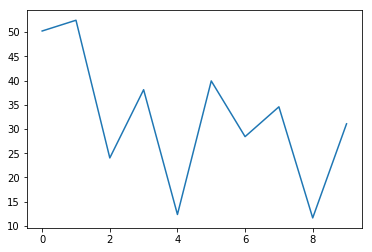

In [11]:
plt.plot(cities10_values)
np.std(cities10_values)

In [12]:
def print_path(cities, x, drones):
    c = np.array(cities)
    a = [cities[x[0]]]
    for i in range(1, len(cities)):
        if not (drones[i-1] == 0 and drones[i] == 1):
            a.append(cities[x[i]])
    a.append(cities[x[0]])
    a = np.array(a)


    b = [cities[x[0]]]
    tempIndex = 0
    for i in range(1, len(drones)):
        if (drones[i-1] + drones[i] == 1):
            b.append(cities[x[i]])

    b.append(cities[x[0]])
    b = np.array(b)



    plt.scatter(c[:, 0] , c[:, 1])

    plt.scatter(c[:, 0] , c[:, 1])

    plt.plot(a[:, 0], a[:, 1])
    plt.plot(b[:, 0], b[:, 1])

    plt.plot(cities[x[0]][0], cities[x[0]][1], 'bo')
    plt.show()
    

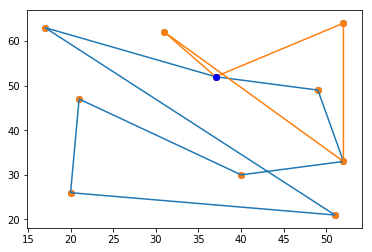

In [22]:
print_path(cities10, cities10_path[0], cities10_drones[0])

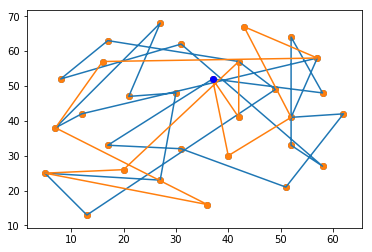

In [21]:
print_path(cities30, cities30_path[0], cities30_drones[0])